<h1><center>Sepsis Prediction</h1>
<h4>TCSS 555<br>
Spring 2018<br>
Thuan Lam, Tood Robbins, Inno Irving Estrera</h4></center>


<h2>Libraries</h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.utils import shuffle
from dateutil.parser import parse
from datetime import datetime

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

## User specific settings

In [2]:
import os 
cwd = os.getcwd()
print('Current folder is {}'.format(cwd))

if os.name == "posix":
    USER_DIR = '/Users/innoestrera/Desktop/mimic3/';
else:
    USER_DIR = 'C:\mimic3\\';
print(USER_DIR)

Current folder is /Users/innoestrera/repositories/Project-3-Sepsis
/Users/innoestrera/Desktop/mimic3/


In [3]:
def convertToEpoch(dob):
    pattern = '%Y-%m-%d %H:%M:%S'
    epoch = int(time.mktime(time.strptime(dob, pattern)))
    return epoch

## Data

In [4]:
# Load datasets
admissions = pd.read_csv("{}ADMISSIONS.csv".format(USER_DIR))[['HADM_ID','SUBJECT_ID']]
drugs = pd.read_csv("{}DRGCODES.csv".format(USER_DIR))[['HADM_ID','SUBJECT_ID','DRG_CODE','DESCRIPTION']]
stays = pd.read_csv("{}NEW_ICUSTAYS.csv".format(USER_DIR))[['HADM_ID','ICUSTAY_ID','LOS']]
chart = pd.read_csv("{}NEW_CHARTEVENTS.csv".format(USER_DIR))
patients = pd.read_csv("{}PATIENTS.csv".format(USER_DIR))
# labitems = pd.read_csv("{}D_LABITEMS.csv".format(USER_DIR))
# labevents = pd.read_csv("{}LABEVENTS.csv".format(USER_DIR), nrows=5)
# microbiologyevents = pd.read_csv("{}MICROBIOLOGYEVENTS.csv".format(USER_DIR), nrows=5)
# callout = pd.read_csv("{}CALLOUT.csv".format(USER_DIR), nrows=5)
# dcpt = pd.read_csv("{}D_CPT.csv".format(USER_DIR), nrows=5)

In [7]:
# add all datasets to array
datasets = {
    'admissions': admissions,
    'drugs': drugs,
    'stays': stays,
    'chart': chart,
    'patients': patients,
#     'labitems': labitems
#     'labevents': labevents,
#     'microbiologyevents': microbiologyevents,
#     'callout': callout,
#     'dcpt': dcpt
}

# remove unimportant itemID features from chart events
# (after running first try, these items returned 0 in feature importance section)
chart = chart[chart.ITEMID != 490]
chart = chart[chart.ITEMID != 1525]
chart = chart[chart.ITEMID != 2981]
chart = chart[chart.ITEMID != 227010]
chart = chart[chart.ITEMID != 227023]
chart = chart[chart.ITEMID != 438]

featuredItemIDs = [220615, 225690, 198, 828, 226755]

In [8]:
for csv in datasets:
    print('{}: \n\t{}'.format(csv, datasets[csv].columns.values))
# print(datasets['admissions'].columns.values)

admissions: 
	['HADM_ID' 'SUBJECT_ID']
drugs: 
	['HADM_ID' 'SUBJECT_ID' 'DRG_CODE' 'DESCRIPTION']
stays: 
	['HADM_ID' 'ICUSTAY_ID' 'LOS']
chart: 
	['ICUSTAY_ID' 'ITEMID' 'VALUE']
patients: 
	['ROW_ID' 'SUBJECT_ID' 'GENDER' 'DOB' 'DOD' 'DOD_HOSP' 'DOD_SSN'
 'EXPIRE_FLAG']


## Create the Y Set

In [9]:
#get a copy with 2 columns only
sepsis = drugs[['HADM_ID', 'DRG_CODE']].copy()

#change drug code 870, 871, 872 to 1; Otherwise, 0
#https://www.icd10monitor.com/understanding-sepsis-an-example-of-the-convergence-of-clinical-quality-coding-reimbursement-and-audit
sepsis['DRG_CODE'] = sepsis['DRG_CODE'].apply(lambda x: 1 if (x >= 870 and x <= 872) or (x >= 867 and x <= 869) or x == 776 or (x >= 974 and x <= 976) else 0)

#sum all drugcodes grouup by HADM_ID. If the sum > 0 means HADM_ID has/had sepsis
sepsis = sepsis.groupby(['HADM_ID']).sum().reset_index() # .sort_values(by=['DRG_CODE'], ascending=False)

#convert DRG_CODE to binary: 1 means sepsis, 0 means NO
sepsis['DRG_CODE'] = sepsis['DRG_CODE'].apply(lambda x: 1 if x > 0 else 0)

#change DRG_CODR to SEPSIS, it would be easier 
sepsis.rename(columns={'DRG_CODE': 'SEPSIS'}, inplace=True)

#merge tables to create the Y set
admissions = pd.merge(admissions, sepsis, on='HADM_ID', how='left') #.drop(['SUBJECT_ID'], axis=1)
admissions = admissions.fillna(0)

## Create the X Set

* <h3>Master

In [10]:
master = pd.merge(admissions, patients, on='SUBJECT_ID', how='inner')
print(master.columns.values)

master = pd.merge(master, drugs, on=['HADM_ID', 'SUBJECT_ID'], how='left')
print(master.columns.values)

master = pd.merge(master, stays, on='HADM_ID', how='left')
print(master.columns.values)

['HADM_ID' 'SUBJECT_ID' 'SEPSIS' 'ROW_ID' 'GENDER' 'DOB' 'DOD' 'DOD_HOSP'
 'DOD_SSN' 'EXPIRE_FLAG']
['HADM_ID' 'SUBJECT_ID' 'SEPSIS' 'ROW_ID' 'GENDER' 'DOB' 'DOD' 'DOD_HOSP'
 'DOD_SSN' 'EXPIRE_FLAG' 'DRG_CODE' 'DESCRIPTION']
['HADM_ID' 'SUBJECT_ID' 'SEPSIS' 'ROW_ID' 'GENDER' 'DOB' 'DOD' 'DOD_HOSP'
 'DOD_SSN' 'EXPIRE_FLAG' 'DRG_CODE' 'DESCRIPTION' 'ICUSTAY_ID' 'LOS']


* <h3>Get ItemIDs from ChartEvents then Add into Master

In [29]:
# NOTE: Delete this comment before submitting, but THIS TAKES A WHILE TO RUN WHEN :(((
# get itemsIds from ChartEvent
for x in chart.ITEMID.unique():
    master[x] = 0

master = master.set_index('ICUSTAY_ID')

In [30]:
print(master.columns.values)

['HADM_ID' 'SUBJECT_ID' 'SEPSIS' 'ROW_ID' 'GENDER' 'DOB' 'DOD' 'DOD_HOSP'
 'DOD_SSN' 'EXPIRE_FLAG' 'DRG_CODE' 'DESCRIPTION' 'LOS' 220615 225690 198
 828 226755]


In [31]:
len(master.index)

133306

In [ ]:
for index, row in chart.iterrows():    
    master.loc[row['ICUSTAY_ID'], row['ITEMID']] = row['VALUE']

In [34]:
master.head(n=10)

HADM_ID  SUBJECT_ID  SEPSIS  ROW_ID GENDER                  DOB  \
ICUSTAY_ID                                                                    
 204798.0    165315          22     0.0      19      F  2131-05-07 00:00:00   
 227807.0    152223          23     0.0      20      M  2082-07-17 00:00:00   
 234044.0    124321          23     0.0      20      M  2082-07-17 00:00:00   
 234044.0    124321          23     0.0      20      M  2082-07-17 00:00:00   
 234044.0    124321          23     0.0      20      M  2082-07-17 00:00:00   
 262236.0    161859          24     0.0      21      M  2100-05-31 00:00:00   
 203487.0    129635          25     0.0      22      M  2101-11-21 00:00:00   
 244882.0    197661          26     0.0      23      M  2054-05-04 00:00:00   
NaN          134931          27     0.0      24      F  2191-11-30 00:00:00   
 225559.0    162569          28     0.0      25      M  2103-04-15 00:00:00   

                            DOD DOD_HOSP              DOD_SSN  EXPIRE_FLAG  \
ICUSTAY_ID                                                                   
 204798.0                   NaN      NaN                  NaN            0   
 227807.0                   NaN      NaN                  NaN            0   
 234044.0                   NaN      NaN                  NaN            0   
 234044.0                   NaN      NaN                  NaN            0   
 234044.0                   NaN      NaN                  NaN            0   
 262236.0                   NaN      NaN                  NaN            0   
 203487.0                   NaN      NaN                  NaN            0   
 244882.0   2128-02-25 00:00:00      NaN  2128-02-25 00:00:00            1   
NaN                         NaN      NaN                  NaN            0   
 225559.0                   NaN      NaN                  NaN            0   

            DRG_CODE                                        DESCRIPTION  \
ICUSTAY_ID                                                                
 204798.0      450.0  POISONING & TOXIC EFFECTS OF DRUGS AGE >17 WIT...   
 227807.0      109.0           CORONARY BYPASS WITHOUT CARDIAC CATHETER   
 234044.0       25.0  CRANIOTOMY & ENDOVASCULAR INTRACRANIAL PROCEDU...   
 234044.0      212.0                       Craniotomy Except for Trauma   
 234044.0      212.0                       Craniotomy Except for Trauma   
 262236.0      526.0  PERCUTANEOUS CARDIOVASCULAR PROCEDURE WITH DRU...   
 203487.0      526.0  PERCUTANEOUS CARDIOVASCULAR PROCEDURE WITH DRU...   
 244882.0      515.0  CARDIAC DEFIBRILLATOR IMPLANT WITHOUT CARDIAC ...   
NaN            390.0            NEONATE WITH OTHER SIGNIFICANT PROBLEMS   
 225559.0      109.0           CORONARY BYPASS WITHOUT CARDIAC CATHETER   

               LOS  220615  225690        198         828  226755  
ICUSTAY_ID                                                         
 204798.0   1.1438    0.00     0.0  11.666667    0.000000     0.0  
 227807.0   1.2641    0.00     0.0  11.000000  117.000000     0.0  
 234044.0   1.1862    0.65     0.0   0.000000    0.000000     0.0  
 234044.0   1.1862    0.65     0.0   0.000000    0.000000     0.0  
 234044.0   1.1862    0.65     0.0   0.000000    0.000000     0.0  
 262236.0   0.5124    0.00     0.0  15.000000  209.000000     0.0  
 203487.0   3.5466    0.00     0.0  15.000000  218.333333     0.0  
 244882.0   2.1407    0.00     0.0  15.000000  168.000000     0.0  
NaN            NaN    0.00     0.0   0.000000    0.000000     0.0  
 225559.0   1.1224    0.00     0.0  12.166667  143.500000     0.0

## Preprocess data

In [36]:
# move the SEPSIS column to the last 
cols = master.columns.tolist()
cols.insert(len(master.columns) - 1, cols.pop(cols.index('SEPSIS')))
master = master.reindex(columns= cols).reset_index()

# remove unnecessary columns
master.drop(['ICUSTAY_ID','ROW_ID', 'HADM_ID','SUBJECT_ID', 'DOD', 'DOD_HOSP', 'DOD_SSN', 'EXPIRE_FLAG', 'DRG_CODE'], axis=1, inplace=True)
# print(master.head(2))
print('Master built. Shape: {}'.format(master.shape))
print(master.columns.values)

master.fillna(0, inplace=True)
master = shuffle(master)
# master = master[:30000]

master.GENDER = master.GENDER.apply(lambda x: 0 if x == 'F' else 1)
# master.DOB = master.DOB.apply(lambda x: convertToEpoch(x))

master.head(n=10)

ValueError: labels ['ICUSTAY_ID' 'ROW_ID' 'HADM_ID' 'SUBJECT_ID' 'DOD' 'DOD_HOSP' 'DOD_SSN'
 'EXPIRE_FLAG' 'DRG_CODE'] not contained in axis

In [43]:
# master.DOB = master.DOB.apply(lambda x: convertToEpoch(x))
# master.head(n=10)

OverflowError: mktime argument out of range

In [51]:
datetime.utcnow()

datetime.datetime(2018, 6, 4, 3, 15, 20, 974317)

## Feature Importance

In [28]:
# Split-out validation dataset
print(master.columns.values)
col = len(master.columns) - 1
array = master.values   #numpy array
X = array[:,0:col]# first N columns
Y = array[:,col]  # SEPSIS column

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250, random_state=0)

forest.fit(X, Y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

['LOS' 220615 225690 198 828 226755 'SEPSIS']
Feature ranking:
1. feature 0 (0.513934)
2. feature 1 (0.230403)
3. feature 2 (0.152368)
4. feature 4 (0.059181)
5. feature 3 (0.042982)
6. feature 5 (0.001131)


## Analyze

## Model

In [114]:
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)
# print('{}'.format(X_train, Y_train))

In [115]:
# Test options and evaluation metric
seed = 7
scoring = 'accuracy'

# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.964673 (0.003578)
KNN: 0.961723 (0.004495)
CART: 0.951567 (0.003992)
NB: 0.143461 (0.146435)
RF: 0.959885 (0.003236)


In [116]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

accuracy 0.9643133462282398
confusion Matrix [[9970    4]
 [ 365    1]]
precision [0.03539652 0.2        1.        ]
recall [1.         0.00273224 0.        ]
sensitivity 0.9995989572889513
specificity 0.00273224043715847
stuff (array([0.00000000e+00, 4.01042711e-04, 1.00000000e+00]), array([0.        , 0.00273224, 1.        ]), array([2., 1., 0.]))


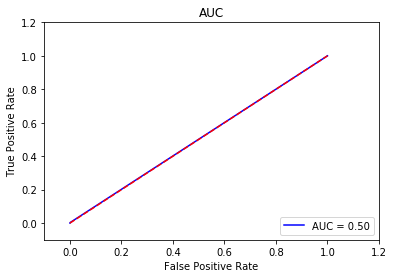

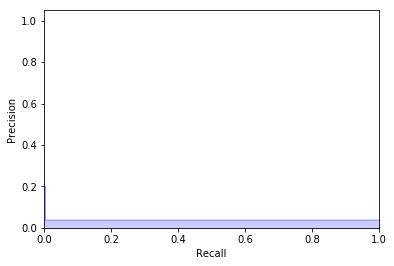

accuracy 0.9618955512572533
confusion Matrix [[9942   32]
 [ 362    4]]
precision [0.03539652 0.11111111 1.        ]
recall [1.         0.01092896 0.        ]
sensitivity 0.9967916583116102
specificity 0.01092896174863388
stuff (array([0.        , 0.00320834, 1.        ]), array([0.        , 0.01092896, 1.        ]), array([2., 1., 0.]))


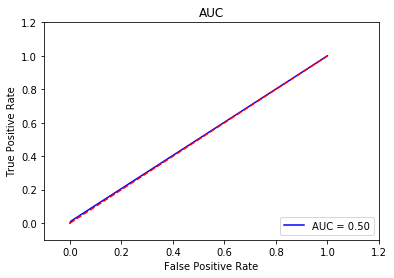

accuracy 0.9516441005802708
confusion Matrix [[9815  159]
 [ 341   25]]
precision [0.03539652 0.13586957 1.        ]
recall [1.         0.06830601 0.        ]
sensitivity 0.9840585522358131
specificity 0.06830601092896176
stuff (array([0.        , 0.01594145, 1.        ]), array([0.        , 0.06830601, 1.        ]), array([2., 1., 0.]))


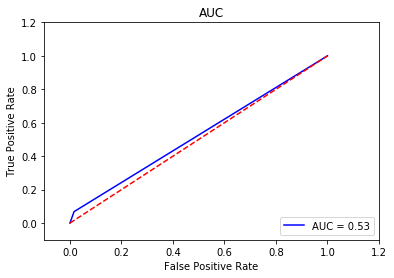

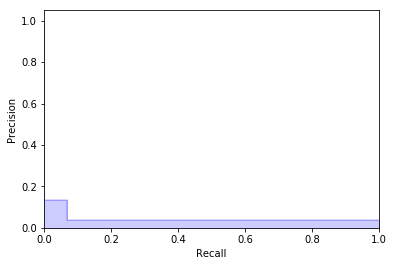

accuracy 0.07127659574468086
confusion Matrix [[ 379 9595]
 [   8  358]]
precision [0.03539652 0.03596905 1.        ]
recall [1.         0.97814208 0.        ]
sensitivity 0.03799879687186685
specificity 0.9781420765027322
stuff (array([0.       , 0.9620012, 1.       ]), array([0.        , 0.97814208, 1.        ]), array([2., 1., 0.]))


accuracy 0.9590909090909091
confusion Matrix [[9910   64]
 [ 359    7]]
precision [0.03539652 0.09859155 1.        ]
recall [1.         0.01912568 0.        ]
sensitivity 0.9935833166232204
specificity 0.01912568306010929
stuff (array([0.        , 0.00641668, 1.        ]), array([0.        , 0.01912568, 1.        ]), array([2., 1., 0.]))


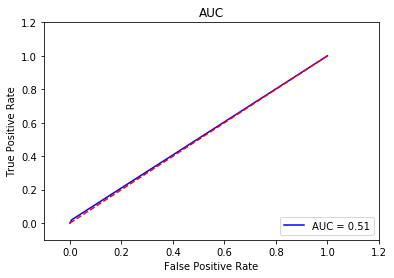

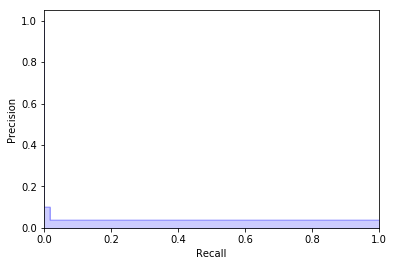

In [117]:
# Make predictions on validation dataset

messages = []
matrices = []
for name, model in models:
    model.fit(X_train, Y_train)
    prediction = model.predict(X_validation)
    
    accuracyScore = accuracy_score(Y_validation, prediction)
    confusionMatrix = confusion_matrix(Y_validation, prediction)
    classificationReport = classification_report(Y_validation, prediction)
    precision, recall, thresholds = precision_recall_curve(Y_validation, prediction)
    sensitivity = confusionMatrix[0, 0]/(confusionMatrix[0, 0]+confusionMatrix[0, 1])
    specificity = confusionMatrix[1, 1]/(confusionMatrix[1, 0]+confusionMatrix[1, 1])
    false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_validation, prediction)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    #metrics.roc_curve(Y_validation, prediction)
    #auc = metrics.auc(confusionMatrix[0, 0], confusionMatrix[1, 1])
    
    print("accuracy", accuracyScore)
    print("confusion Matrix", confusionMatrix)
    print("precision", precision)
    print("recall", recall)
    print("sensitivity", sensitivity)
    print("specificity", specificity)
    print("stuff", roc_curve(Y_validation, prediction))
    plt.title('AUC')
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    plt.step(recall, precision, color='b', alpha=0.2,where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()
    #matrices.append(confusionMatrix)
    
#print(confusionMatrix)
#print(messages)

## Conclusion

<h4> bla bla bla. <h4>

Feature ranking:
1. feature 0 (0.381667)
2. feature 1 (0.305170)
3. feature 3 (0.133190)
4. feature 2 (0.087885)
5. feature 4 (0.087751)
6. feature 6 (0.002220)
7. feature 5 (0.002106)
8. feature 9 (0.000005)
9. feature 10 (0.000004)
10. feature 7 (0.000003)
11. feature 8 (0.000000)


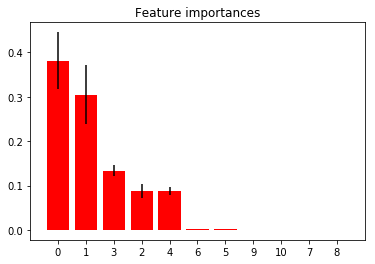

In [120]:
all_rows = master.shape[0]
sepsis_rows = len(master[(master['SEPSIS'] == 1)])
baseline = 1 -(sepsis_rows / all_rows)
print('Sepsis: {} rows out of {} rows'.format(sepsis_rows, all_rows))
print('Baseline: {}'.format(baseline))

Sepsis: 1815 rows out of 51696 rows
Baseline: 0.9648909006499535
